In [99]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../../utils/")

import matplotlib.pyplot as plt
%matplotlib inline
import pdb
import requests
import re

import pandas as pd

import networkx as nx

import signal

import warnings
warnings.filterwarnings("ignore")

from wiki_intro_scrapper import WikiIntroScrapper
from WikiMultiQuery import wiki_multi_query
from graph_helpers import create_dispersion_df, sort_dict_values

%aimport wiki_intro_scrapper
%aimport WikiMultiQuery

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'sort_dict_values' from 'graph_helpers' (../../utils/graph_helpers.py)

In [112]:
class GraphCreator:

    def __init__(self, entry):
        self.graph = nx.DiGraph()
        
        self.entry = entry
        
        self.visited = {entry}
        self.next_links = []
        
        self.query_articles([entry])
        

        # setup timeout function
        def handle_alarm(signum, frame):
            raise RuntimeError

        signal.signal(signal.SIGALRM, handle_alarm)

    def add_edges(self, articles):
        for article in articles:
            self.graph.add_edges_from([(article['title'], link) for link in article['links']])
            self.graph.add_edges_from([(linkhere, article['title']) for linkhere in article['linkshere']])

    def plot_graph(self):
        nx.draw(self.graph)
        plt.show()

    def get_degrees(self):
        return sorted([(key, val) for key, val in dict(self.graph.degree()).items()], key=lambda x: x[1], reverse=True)

    def get_centrality(self, sort_results=False):
        if sort_results:
            return sorted([(key, val) for key, val in dict(nx.eigenvector_centrality(self.graph)).items()], key=lambda x: x[1], reverse=True)
        else:
            return nx.eigenvector_centrality(self.graph)
        
    def create_ego(self, node=None):
        if not node:
            node = self.entry
            
        ego = nx.ego_graph(self.graph, node)
        ego.name = node
        return ego

    def expand_network(self, group_size=10, timeout=10):
        
        num_links = len(self.next_links)
        
        link_group = []
        
        for i in range(num_links):
            link = self.next_links.pop(0)
            if not link in self.visited:
                
                link_group.append(link)
                
                if len(link_group) == group_size or (i == num_links - 1 and len(link_group) > 0):
                    print("{:.2%}".format(i/num_links))
                    try:
                        signal.alarm(timeout)
                        self.visited.update(link_group)
                        self.query_articles(link_group)
                        signal.alarm(0)
                        link_group = []
                    except:
#                         print("==SKIPPED==")
                        link_group = []
                        continue
        signal.alarm(0)
    
    def update_next_links(self, articles):
        for article in articles:
            for link in article['links']:
                self.next_links.append(link)
            
        
    def query_articles(self, titles, generate_graph=True):            
        articles = wiki_multi_query(titles)
        
        self.update_next_links(articles)
        self.add_edges(articles)


## TESTS

In [119]:
gc = GraphCreator("Random forest")
wis = WikiIntroScrapper("https://en.wikipedia.org/wiki/Random forest")
wis.parse_intro_links();

In [120]:
gc.expand_network(group_size=5, timeout=20)

2.94%
6.62%
10.29%
13.97%
17.65%
21.32%
25.00%
28.68%
32.35%
36.03%
39.71%
43.38%
47.06%
50.74%
54.41%
58.09%
61.76%
65.44%
69.12%
72.79%
76.47%
80.15%
83.82%
87.50%
91.18%
94.85%
98.53%
99.26%


In [121]:
wis.intro_link_titles

['Ensemble learning',
 'Statistical classification',
 'Regression analysis',
 'Decision tree learning',
 'Mode (statistics)',
 'Overfitting',
 'Test set',
 'Tin Kam Ho',
 'Random subspace method',
 'Leo Breiman',
 'Trademark',
 'Minitab',
 'Bootstrap aggregating',
 'Donald Geman']

In [122]:
centrality = gc.get_centrality()
print (wis.title, centrality[wis.title])
for title in wis.intro_link_titles:
    print(title, centrality[title])

Random forest 0.07888058451629051
Ensemble learning 0.07871899558876114
Statistical classification 0.16397962643706968
Regression analysis 0.17585932802859114
Decision tree learning 0.08139503753363012
Mode (statistics) 0.09910504417313791
Overfitting 0.02621940766223414
Test set 0.004663040302847933
Tin Kam Ho 0.0009860527375881222
Random subspace method 0.003848056245190222
Leo Breiman 0.007833766210722348
Trademark 0.0013286383920636813
Minitab 0.004317604361931736
Bootstrap aggregating 0.07986424649355205
Donald Geman 0.0009860527375881222


In [123]:
centrality = gc.get_centrality()

rankings = []

rankings.append((wis.title, centrality[wis.title]))
for title in wis.intro_link_titles:
    rankings.append((title, centrality[title]))
    
ranking_df = pd.DataFrame(rankings, columns=["node", "centrality"])
ranking_df.sort_values("centrality", ascending=False).reset_index().drop('index', axis=1)

,node,centrality
0,Regression analysis,0.175859
1,Statistical classification,0.163980
2,Mode (statistics),0.099105
3,Decision tree learning,0.081395
4,Bootstrap aggregating,0.079864
5,Random forest,0.078881
6,Ensemble learning,0.078719
7,Overfitting,0.026219
8,Leo Breiman,0.007834
9,Test set,0.004663


In [30]:
nx.dispersion(gc.graph, u="Decision tree", v="Probability")

0.0

In [94]:
dispersion_df = create_dispersion_df(gc.graph, "Random forest", ranking_df.node)
dispersion_df.sort_values("dispersion")

,entry,node,dispersion
7,Random forest,Test set,0.000000
14,Random forest,Donald Geman,0.000000
8,Random forest,Tin Kam Ho,0.200000
5,Random forest,Mode (statistics),0.923077
11,Random forest,Trademark,1.000000
12,Random forest,Minitab,1.250000
9,Random forest,Random subspace method,1.333333
10,Random forest,Leo Breiman,1.333333
6,Random forest,Overfitting,2.545455
13,Random forest,Bootstrap aggregating,5.655556


In [61]:
page_ranks = sorted([(key, value) for key, value in nx.algorithms.link_analysis.pagerank(gc.graph).items()], key=lambda x: x[1], reverse=True)
page_rank_df = pd.DataFrame(page_ranks, columns=["node", "page_rank"])

page_rank_df.head()

,node,page_rank
0,CiteSeerX,0.117248
1,Mathematical Reviews,0.061393
2,Wikipedia,0.041612
3,Trademark,0.025288
4,Machine learning,0.018037


In [62]:
merged = ranking_df.merge(dispersion_df, on="node", how="inner")
merged = merged.merge(page_rank_df, on="node", how='inner')

merged['weighted_dispersion'] = merged.centrality * merged.dispersion * merged.page_rank 
merged.sort_values("weighted_dispersion", ascending=False)

,node,centrality,entry,dispersion,page_rank,weighted_dispersion
3,Regression analysis,0.175859,Random forest,6.988764,0.006531,8.026285e-03
2,Statistical classification,0.163980,Random forest,6.966292,0.002405,2.747018e-03
0,Random forest,0.078881,Random forest,26.044118,0.000459,9.429199e-04
4,Decision tree learning,0.081395,Random forest,9.552083,0.000525,4.078700e-04
1,Ensemble learning,0.078719,Random forest,8.000000,0.000397,2.502227e-04
5,Mode (statistics),0.099105,Random forest,0.923077,0.002558,2.340274e-04
13,Bootstrap aggregating,0.079864,Random forest,5.655556,0.000388,1.750357e-04
6,Overfitting,0.026219,Random forest,2.545455,0.000577,3.849780e-05
11,Trademark,0.001329,Random forest,1.000000,0.025288,3.359827e-05
12,Minitab,0.004318,Random forest,1.250000,0.001990,1.074017e-05


In [63]:
nx.degree_pearson_correlation_coefficient(gc.graph, nodes=list(ranking_df.node))

0.112383367323201

In [91]:
ego = nx.ego_graph(gc.graph, "Regression analysis", undirected=True)
ego.name = "Regression analysis"
print(nx.info(ego))

Name: Regression analysis
Type: DiGraph
Number of nodes: 1356
Number of edges: 21586
Average in degree:  15.9189
Average out degree:  15.9189


In [85]:
len(ego.nodes)

1356

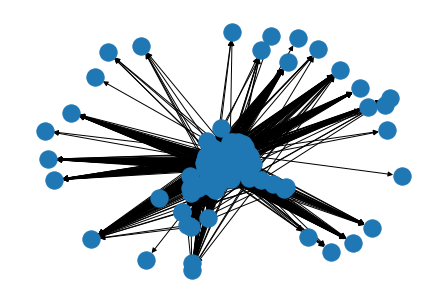

In [72]:
nx.draw(ego)
plt.show()

In [86]:
sorted([(key, value) for key, value in nx.eigenvector_centrality(ego).items()], key=lambda x: x[1], reverse=True)

[('Regression analysis', 0.18353594711110852),
 ('Logistic regression', 0.17438078068932947),
 ('Linear regression', 0.17186450112604035),
 ('Principal component analysis', 0.16901179769955574),
 ('Statistical classification', 0.16860059912192715),
 ('Cluster analysis', 0.16759488703196093),
 ('Graphical model', 0.1663714581252733),
 ('Factor analysis', 0.16568534416430541),
 ('Linear discriminant analysis', 0.16545546770821257),
 ('Cross-validation (statistics)', 0.1160982293550033),
 ('Sampling (statistics)', 0.105700714772082),
 ('Correlation and dependence', 0.10560267700501136),
 ('Nonparametric statistics', 0.10374389165095088),
 ('Mode (statistics)', 0.10358718451871785),
 ('Machine learning', 0.0981766811945859),
 ('Data mining', 0.0872234739176083),
 ('Bayesian network', 0.08688931365486079),
 ('Supervised learning', 0.08472924406452015),
 ('Artificial neural network', 0.08428436728060683),
 ('Perceptron', 0.08344285357632618),
 ('Unsupervised learning', 0.08298558098495137),


In [107]:
def sort_dict_values(dict, columns, sort_column, ascending=False):
    to_list = [(key, value) for key, value in dict.items()]
    return pd.DataFrame(to_list, columns=columns).sort_values(sort_column, ascending=ascending).reset_index().drop("index", axis=1)

In [111]:
regression_ego = sort_dict_values(nx.betweenness_centrality(ego), ["node", "betweenness"], "betweenness")
regression_ego
# regression_ego[regression_ego.node == "Random forest"]

,node,betweenness
0,Regression analysis,0.344939
1,Linear regression,0.030759
2,Logistic regression,0.025836
3,Outline of machine learning,0.020856
4,Principal component analysis,0.019372
5,Cluster analysis,0.018460
6,Statistical classification,0.018011
7,Factor analysis,0.015697
8,Linear discriminant analysis,0.014733
9,Graphical model,0.014608
